In [1]:
import os
import sys
import gc
import importlib
import numpy as np
import netCDF4
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define path
base_FP = '/home/subin/data'
cpuserver_data_FP = '/home/subin/cpuserver_data'
data_2_path = '/home/subin/data_2'

print(base_FP)
print(cpuserver_data_FP)
print(data_2_path)
sys.path.append(base_FP + '/python_modules')

import HydroAI.Data as hData
import HydroAI.Grid as hGrid
import HydroAI.TC_like as hTCL
import HydroAI.Plot as hPlot

importlib.reload(hData);
importlib.reload(hGrid);
importlib.reload(hTCL);
importlib.reload(hPlot);

import warnings
warnings.filterwarnings("ignore")

/home/subin/data
/home/subin/cpuserver_data
/home/subin/data_2


In [ ]:
# Only one year for example
year_list = list(range(2025, 2025 + 1))
vars_list = ['stl1', 'swvl1'] # Example variables
target_filevar_name = 'hydr'
target_time_idx = 0 # Example data's time index {0: 00, 1: 06, 2: 12, 3: 18}
vars_unit_dict = {}

# For loop for each year
for year_idx, year in enumerate(year_list):
    year_file_list = os.listdir(f'{data_2_path}/ERA5_Aurora/{year}')
    year_file_list.sort() # Sort by date
    year_file_list = [f for f in year_file_list if not f.startswith('.')] # Remove hidden files
    print(f"Year {year} file list length: ", len(year_file_list))

    # Read lat and lon (Only once needed)
    with netCDF4.Dataset(f'{data_2_path}/ERA5_Aurora/{year}/{year_file_list[0]}/{year}-01-01_{target_filevar_name}.nc') as nc:
        print(nc.variables.keys()) # Check variables
        nc_lat = nc.variables['latitude'][:].data  # 1D: 90 ~ -90
        nc_lon = nc.variables['longitude'][:].data # 1D: -180 ~ 180
        nc_lon, nc_lat = np.meshgrid(nc_lon, nc_lat) # 2D: 90 ~ -90, -180 ~ 180

        for var in vars_list:
            vars_unit_dict[var] = nc.variables[var].units

    # ===============================================================================
    # Assign data to year_array
    # ===============================================================================

    # Initialize year_array with NaN (lat, lon, time, var)
    year_array = np.full((np.shape(nc_lat)[0], np.shape(nc_lon)[1], len(year_file_list), len(vars_list)), np.nan)

    # Read variables from files
    for time_idx, daily_file in enumerate(tqdm(year_file_list, desc='Processing files')):
        yyyy, mm, dd = daily_file.split('.')
        daily_file_name = f'{data_2_path}/ERA5_Aurora/{year}/{daily_file}/{year}-{mm}-{dd}_{target_filevar_name}.nc'

        with netCDF4.Dataset(daily_file_name) as nc:
            for var_idx, var in enumerate(vars_list):
                temp = nc.variables[var][:].data[target_time_idx, :, :] # (time, lat, lon)
                year_array[:, :, time_idx, var_idx] = temp
    
    # ===============================================================================
    # Create netCDF file
    # ===============================================================================
    # Target netCDF file's name
    new_nc_file_name = f'{data_2_path}/ERA5_Aurora/ERA5_Aurora_{year}.nc'

    # Initialize data_vars
    data_vars = {}
    for var_idx, var in enumerate(vars_list):
        # (data_array, units_string)
        data_vars[var] = (year_array[:, :, :, var_idx], vars_unit_dict[var])

    hData.create_netcdf_file(
        nc_file=new_nc_file_name,
        latitude=nc_lat,
        longitude=nc_lon,
        **data_vars) # keyword arguments

    # Remove memory
    data_vars = {}
    del year_array, nc_lat, nc_lon
    gc.collect()

Year 2025 file list length:  335
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'swvl1', 'swvl2', 'swvl3', 'swvl4'])


Processing files: 100%|██████████| 335/335 [01:00<00:00,  5.57it/s]


NetCDF file /home/subin/data_2/ERA5_Aurora/ERA5_Aurora_2025.nc created successfully with units.


stl1 shape & units: (721, 1440, 335) K
220.76384 311.46698


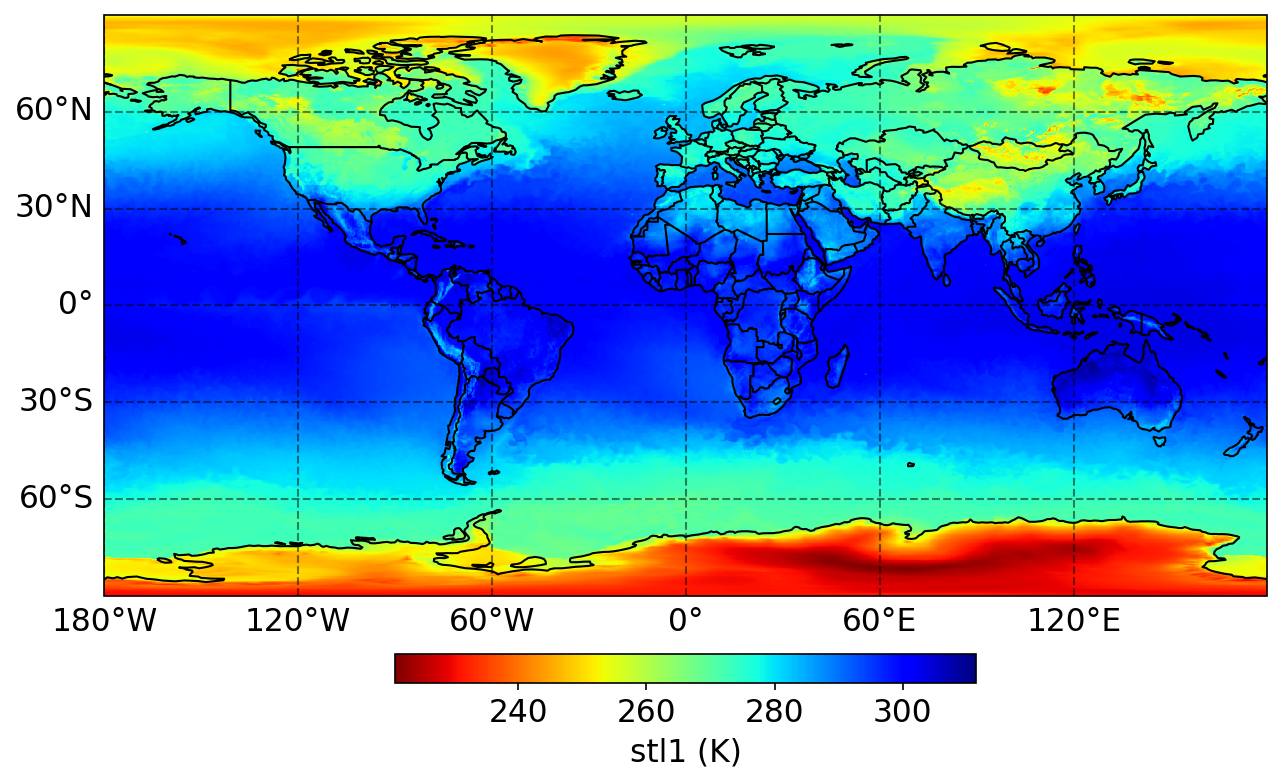

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [24]:
load_nc_path = f'{data_2_path}/ERA5_Aurora/ERA5_Aurora_{year}.nc'
with netCDF4.Dataset(load_nc_path) as nc:
    nc_lat = nc.variables['latitude'][:].data
    nc_lon = nc.variables['longitude'][:].data

    nc_var = nc.variables[f'{vars_list[0]}']
    nc_var_data = nc_var[:]
    nc_var_units = nc_var.units

print(f'{vars_list[0]} shape & units:', np.shape(nc_var_data), nc_var_units)
target = nc_var_data[:, :, -1] # Last time step

cmin = np.nanmin(target)
cmax = np.nanmax(target)
print(cmin, cmax)

hPlot.plot_map(nc_lon, nc_lat, target, cmin=cmin, cmax=cmax, 
                label_title=f"{vars_list[0]} ({nc_var_units})", 
                #cbar_extend='both', 
                cmap='jet_r', projection='PlateCarree')
